In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from scipy.io import readsav

import datetime
import matplotlib.dates as date

from matplotlib import animation, rc
from IPython.display import HTML

import sys
sys.path.append("../")
from iris2gauss import fit2gauss

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm
# Rebuild the matplotlib font cache
fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1

clrs = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']
clrs2 = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
clrs3 = ['#006BA4', '#FF800E', '#ABABAB', '#595959','#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
plt.rcParams['text.usetex'] = True

In [4]:
path = '/Users/WilliamHenryAshfieldIV/dat/iris/'
filename = 'raster_data.sav'
fn = path+filename

In [5]:
ro = readsav(fn,verbose=False,python_dict=False)

In [6]:
Int = ro.d['INT'][0]
wvl = ro.d['WVL'][0]
err = ro.d['ERR'][0]

data = Int[69,:,:]/4. # raster px=69, the one we want. - divide to put into DN/s
error = err[69,:,:]/4.

# trim:
jj = np.where((wvl > 1402) & (wvl < 1404))[0] 
data = data[:,jj]
error = error[:,jj]
wvl = wvl[jj]

In [7]:
i_str,i_end = 1200,1600
intt = ro.d['int'][0]
time_iris = ro.d['time_ccsds'][0]
time_iris = time_iris[i_str:i_end]
datr = data[i_str:i_end,:]

In [8]:
it = np.arange(i_str,i_end) # subrange of time (in index) to fit
N = len(it)

In [9]:
tm_iris = np.zeros(len(time_iris))
for i in range (0,len(time_iris)):
    time_string = time_iris[i].decode("utf-8")
    datetime_object = datetime.datetime.strptime(time_string, '%Y-%m-%dT%H:%M:%S.%f')
    tm_iris[i] = date.date2num(datetime_object)

In [10]:
v_r = np.zeros(N)
v_b = np.zeros(N)
w_r = np.zeros(N)
w_b = np.zeros(N)
amp = np.zeros(N)

y1g_arr = np.zeros((N,79))
y2a_arr = np.zeros((N,79))
y2b_arr = np.zeros((N,79))

for i in range(0,N):
    
    t_i = it[i]
    dt = data[t_i,:]
    er = error[t_i,:]
        
    res = fit2gauss(wvl,dt,er,chi_thr=5.,fit_indy=True)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]
    
    y1g_arr[i,:] = res["y1g"]
    y2a_arr[i,:] = res["y2a"]
    y2b_arr[i,:] = res["y2b"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5

    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(0.0, 50.0)

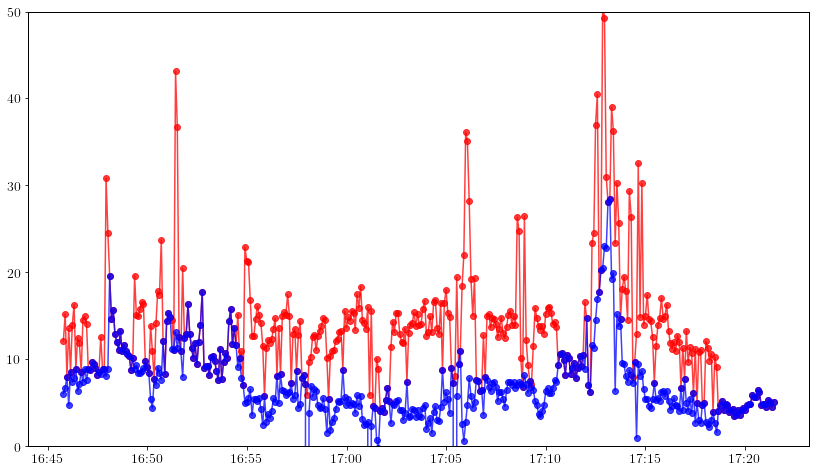

In [11]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot_date(tm_iris,v_r,'r',alpha=0.75,marker='o')
ax.plot_date(tm_iris,v_b,'b',alpha=0.75,marker='o')
plt.ylim(0,50)

ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M'))
ax.set_ylim(0,50)

In [12]:
v_b[220] = v_r[220] # w/ quick fix..
v_r[221] = v_b[221] 

(16368.71180439815, 16368.713357523147)

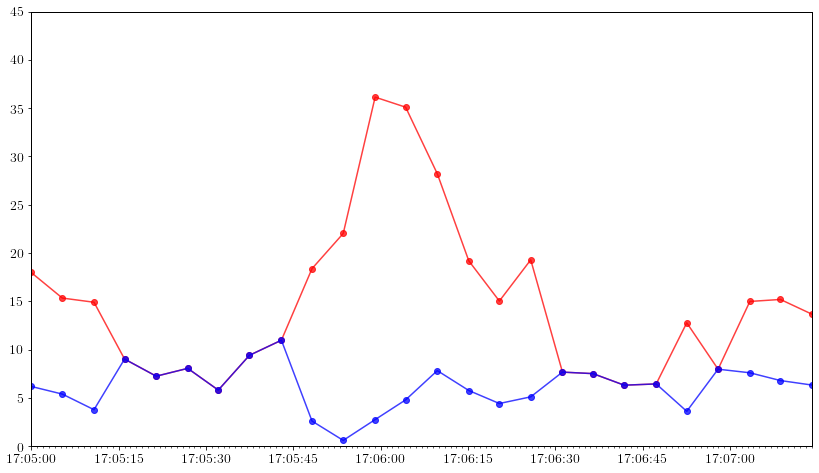

In [13]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot_date(tm_iris,v_r,'r',alpha=0.75,marker='o')
ax.plot_date(tm_iris,v_b,'b',alpha=0.75,marker='o')
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
ax.set_ylim(0,45)
ax.set_xlim([tm_iris[215], tm_iris[240]])
#ax.set_xlim(215,240)

In [14]:
ts = np.arange(1424,1430)-1200
nn = len(ts)

In [15]:
from scipy.optimize import curve_fit
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [16]:
vr = v_r[226:238] # rather than 238
tm_s = tm_iris[226:238]

In [17]:
dtr = date.num2date(tm_s)
ref_time = dtr[0]
tm_fit = np.zeros(len(dtr))
#strg = dtr.strftime("%S")
for i in range(0,len(dtr)):
    string = dtr[i].strftime("%S.%f")
    tm_fit[i]=float(string)
tm_fit[0] -=60.0
tm_fit += np.abs(tm_fit[0])

In [18]:
a0= [35,15]
popt, pcov = curve_fit(u0_fit, tm_fit, vr,p0=a0)
vr_fit = u0_fit(tm_fit,*popt)

In [19]:
# "interpolate" the fit..
tm_fitII = np.arange(0,60,0.5)
vr_fitII = u0_fit(tm_fitII,*popt)

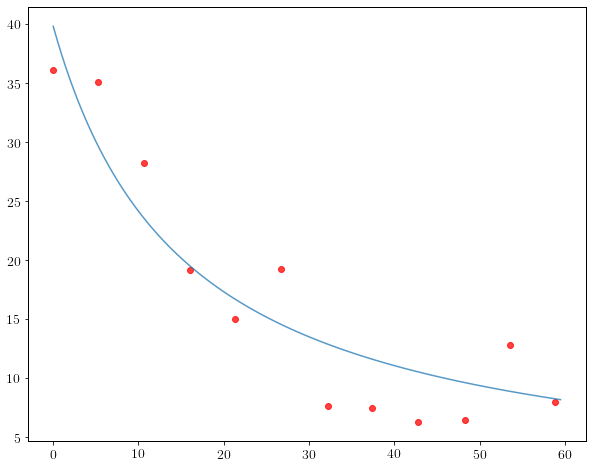

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tm_fit,vr,'r' 'o',alpha=0.75)
ax.plot(tm_fitII,vr_fitII,'-',alpha=0.75)

In [21]:
vr_iris = vr
%store vr_iris
%store vr_fitII
%store tm_fit
%store tm_fitII

Stored 'vr_iris' (ndarray)
Stored 'vr_fitII' (ndarray)
Stored 'tm_fit' (ndarray)
Stored 'tm_fitII' (ndarray)


In [22]:
dtrII = [ref_time + datetime.timedelta(seconds=i) for i in tm_fitII]
tms = date.date2num(dtrII)

In [23]:
H = 0.6*popt[0]*popt[1]
print('H = ', H)
print('tau = ',popt[1])
print('max vel = ',popt[0])

H =  368.57229445192087
tau =  15.420134026003653
max vel =  39.836693791634275


(16368.71192986111, 16368.713233796298)

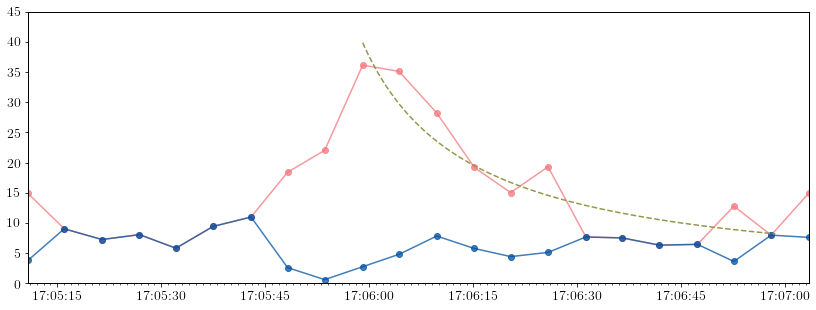

In [24]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot_date(tm_iris,v_r,'-',color = clrs[3],alpha=0.75,marker='o')
ax.plot_date(tm_iris,v_b,'-',color = clrs[0],alpha=0.75,marker='o')
ax.plot_date(tms,vr_fitII,'--',color = clrs[1])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())

ax.set_ylim(0,45)
ax.set_xlim([tm_iris[217], tm_iris[238]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

Text(0.5, 0, 'wavlength [$\\AA$]')

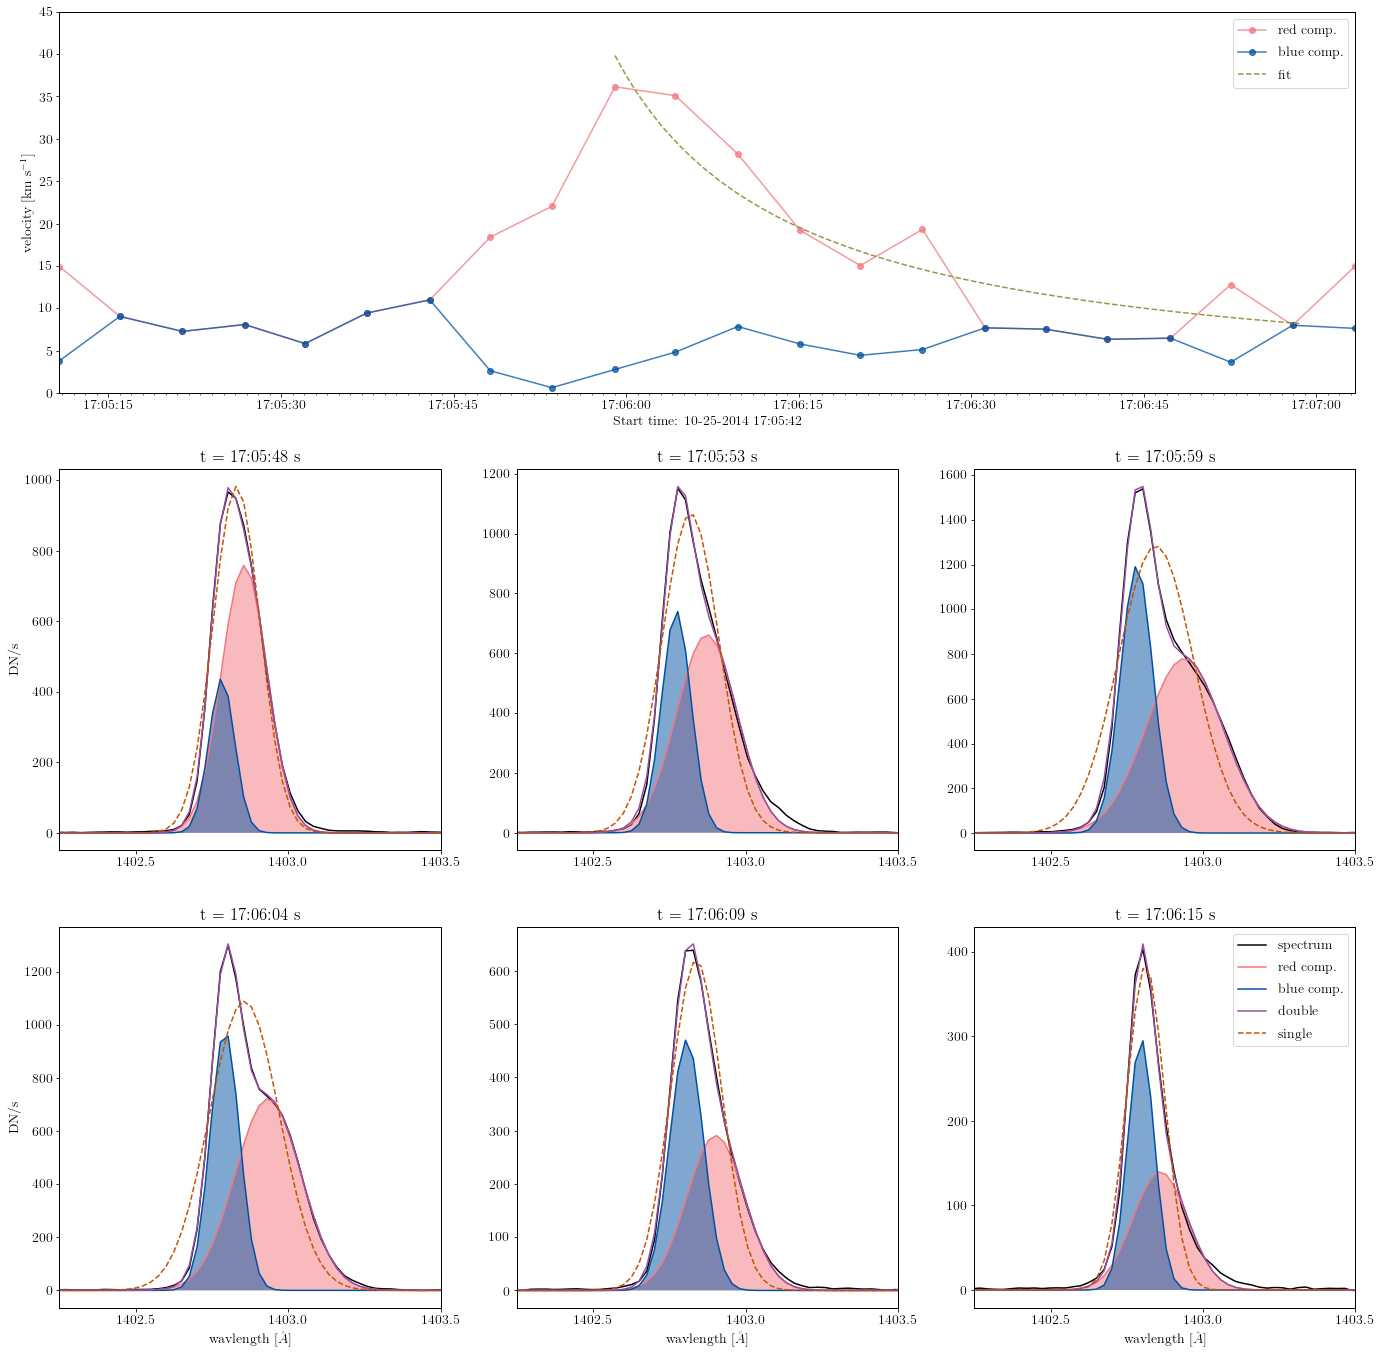

In [25]:
ts2d = np.reshape(ts, (2, 3))

fig7 = plt.figure(figsize=(20, 20),constrained_layout=False)
gs1 = fig7.add_gridspec(3,3,left=0.05, right=0.95,top = 0.95,bottom=0.05)
ax = fig7.add_subplot(gs1[0, :])

ax.plot_date(tm_iris,v_r,'-',color = clrs[3],alpha=0.75,marker='o',label='red comp.')
ax.plot_date(tm_iris,v_b,'-',color = clrs[0],alpha=0.75,marker='o',label='blue comp.')
ax.plot_date(tms,vr_fitII,'--',color = clrs[1],label='fit')

ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
ax.set_ylim(0,45)
ax.set_xlim([tm_iris[217], tm_iris[238]])
dtr = date.num2date(tm_iris[223])
strg = dtr.strftime("%H:%M:%S")
ax.set_ylabel('velocity [km s$^{-1}$]')
ax.set_xlabel('Start time: 10-25-2014 '+strg)
ax.legend()

#for j in range(0,nn):
for row in range(1,3):
    for col in range(3):
        ax1 = fig7.add_subplot(gs1[row, col])
        
        rows = row-1
        k = ts2d[rows,col]
    
        y2a = y2a_arr[k]
        y2b = y2b_arr[k]
        y1g = y1g_arr[k]
        dat = datr[k]

        # spectrum
        ax1.plot(wvl, dat, color = 'black',label='spectrum')
        # peak 1
        if np.array_equal(y2a+y2b, y1g): 
            clr = clrs3[5]
        else: 
            clr = clrs[3]
        ax1.plot(wvl, y2a, color = clr,label = 'red comp.')
        
        ax1.fill_between(wvl, y2a.min(), y2a, facecolor= clr, alpha=0.5)
        ax1.plot(wvl, y2b, color = clrs[0],label = 'blue comp.')        # peak 2
        ax1.fill_between(wvl, y2b.min(), y2b, facecolor= clrs[0], alpha=0.5) 

        ax1.plot(wvl,y2a+y2b, color = clrs2[5],label = 'double')         #both
        ax1.plot(wvl,y1g,'--',color=clrs3[5],label = 'single')        # single fit

        ax1.set_xlim(1402.25,1403.5)
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        dtr = date.num2date(tm_iris[k])
        strg = dtr.strftime("%H:%M:%S")
        ax1.set_title('t = '+strg+' s')

        if k==229: 
            ax1.legend()

ax2 = fig7.add_subplot(gs1[1,0])
ax2.set_ylabel('DN/s')

ax7 = fig7.add_subplot(gs1[2,0])
ax7.set_xlabel("wavlength [$\AA$]")
ax7.set_ylabel('DN/s')
ax8 = fig7.add_subplot(gs1[2,1])
ax8.set_xlabel("wavlength [$\AA$]")
ax9 = fig7.add_subplot(gs1[2,2])
ax9.set_xlabel("wavlength [$\AA$]")

In [51]:
#fig7.savefig('px69_tm170559.pdf', format='pdf', edgecolor='w',facecolor='w', dpi = 700)